# Time Series Analysis of BNB/USDT 1m Data
**Author:** Michael Childress  
**Date:** 2025‑04‑18 

_This notebook documents data loading, visualization, decomposition, stationarity tests, and interpretation._

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# ensure plots folder exists
plots_dir = './plots'
os.makedirs(plots_dir, exist_ok=True)
# load data
df = pd.read_csv(
    '/Users/mchildress/ts_basics/data/bnbusdt_1m.csv',
    parse_dates=['open_time'], index_col='open_time'
)
price = df['close']
subset = price.tail(10080)

# Quick summary of your DataFrame
print("Total rows:    ", df.shape[0])
print("Columns:       ", df.columns.tolist())
print("Index name:    ", df.index.name)
print("Index freq:    ", df.index.freq or "Not set—use .asfreq('T') to enforce 1min")

Total rows:     3675432
Columns:        ['close_time', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_volume', 'taker_buy_quote_volume', 'timestamp']
Index name:     open_time
Index freq:     Not set—use .asfreq('T') to enforce 1min


## 1. Dataset Overview
- **Total rows:** 3,675,432  
- **Columns:**  
  `['close_time', 'open', 'high', 'low', 'close', 'volume',  
    'quote_asset_volume', 'number_of_trades',  
    'taker_buy_base_volume', 'taker_buy_quote_volume', 'timestamp']`  
- **Index:**  
  A `pandas.DatetimeIndex` named **open_time**, which marks the **start** of each 1‑minute interval.  

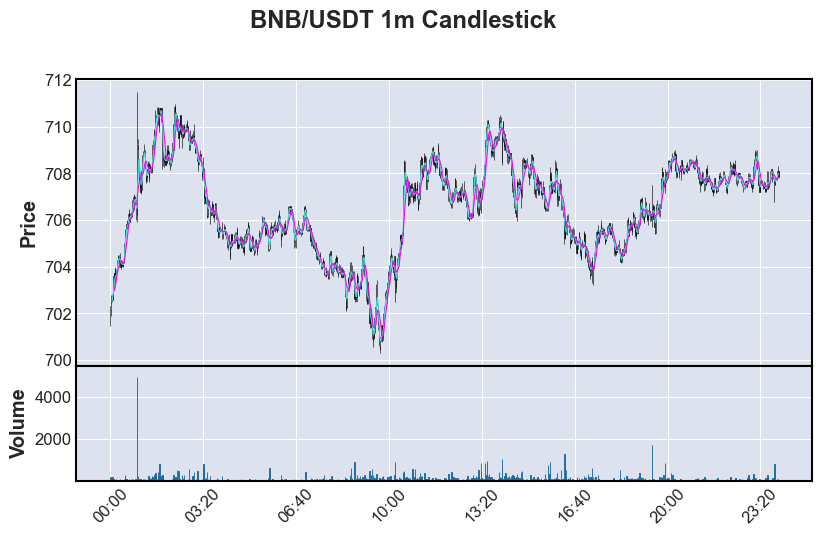

In [ ]:
ohlc = df[['open', 'high', 'low', 'close', 'volume']].tail(1440)
mpf.plot(
    ohlc, type='candle', mav=(5, 10), volume=True,
    title='BNB/USDT 1m Candlestick', figratio=(16, 9),
    datetime_format='%H:%M',
    warn_too_much_data=2000
)

**Discussion: Candlestick & Volume**

- **Rapid swings in price**  
  Notice several periods where individual 1‑minute candles have long bodies and wicks, indicating quick shifts in buying vs. selling pressure within minutes.

- **Volume bursts coincide with big moves**  
  The tallest volume bars line up exactly with those large candles. High trading volume appears to drive or confirm those rapid price moves.

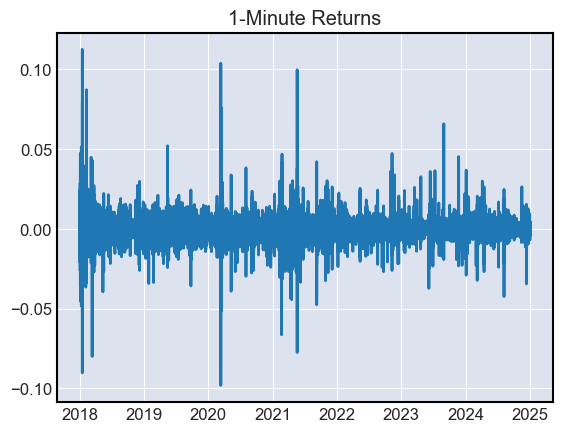

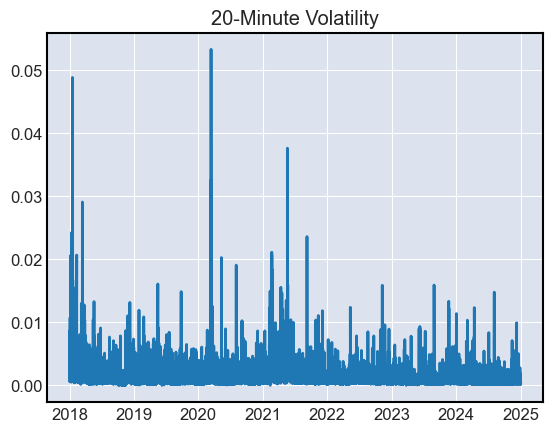

In [ ]:
returns = price.pct_change().dropna()
plt.figure()
plt.plot(returns)
plt.title('1-Minute Returns')
plt.show()

volatility = returns.rolling(20).std()
plt.figure()
plt.plot(volatility)
plt.title('20-Minute Volatility')
plt.show()

**Discussion: Returns**

- **Fat‑tailed return spikes**  
  You see one‑minute returns jumping as high as +2% or dropping –2% in extreme moves—far beyond what a normal distribution would predict.

- **Volatility clustering**  
  Clusters of large positive and negative returns occur in bursts. Once volatility rises, it tends to stay elevated for several minutes before calming down again.

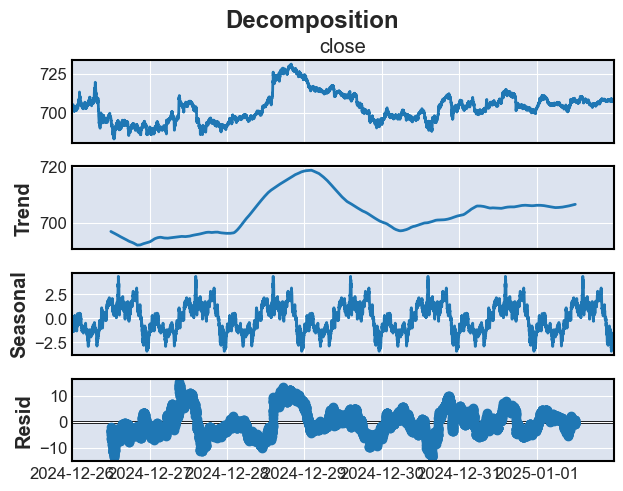

In [ ]:
decomp = seasonal_decompose(subset, model='additive', period=1440)
decomp.plot()
plt.suptitle('Decomposition', y=1.02)
plt.show()

**Discussion: Trend & Seasonality**

- **Upward drift over the week**  
  The trend component shows a steady, slight rise in the close price across these seven days, reflecting BNB’s overall bullish bias in that timeframe.

- **Clear daily cycle**  
  The seasonal component repeats every 1440 minutes (24 hours). Price (and implied activity) tends to peak at roughly the same times each day—likely when multiple regional markets overlap—then pull back overnight.

ADF p‑value: 0.08993032477014057
KPSS p‑value: 0.01


/var/folders/yj/3s0hc5nn3qlg4lqp7wmfgq_c0000gn/T/ipykernel_60855/566856591.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(subset.dropna(), regression='c', nlags='auto')


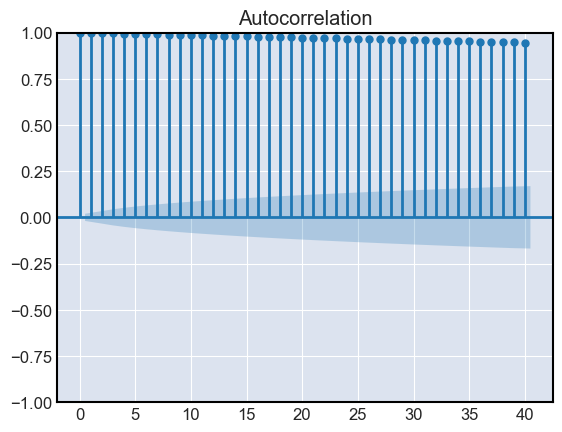

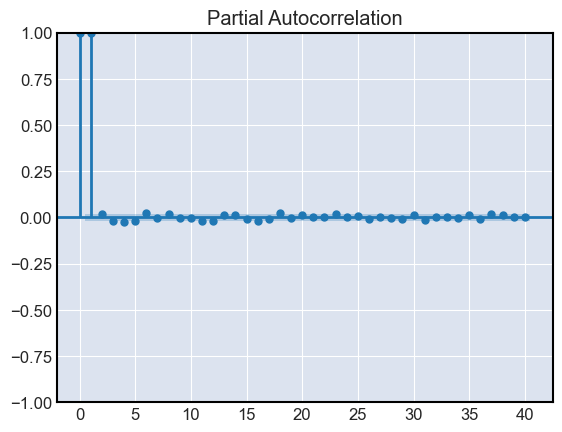

In [ ]:
adf_stat, adf_p, *_ = adfuller(subset.dropna())
print('ADF p‑value:', adf_p)

kpss_stat, kpss_p, *_ = kpss(subset.dropna(), regression='c', nlags='auto')
print('KPSS p‑value:', kpss_p)

plot_acf(subset.dropna(), lags=40)
plt.show()
plot_pacf(subset.dropna(), lags=40)
plt.show()

**Discussion: Stationarity & Autocorrelation**

- **ADF fails to reject non‑stationarity** (p ≈ 0.09) → the series still has trend/cycle.  
- **KPSS rejects stationarity** (p = 0.01) → confirms non‑stationary behavior.  
- **ACF & PACF structure**  
  - ACF: large lag‑1 autocorrelation plus a daily‑cycle spike at lag 1440.  
  - PACF: cuts off after lag 1 (or lag 2) → points toward an AR(1) as value at t depends on value at t–1.